In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pysolr
import os

SOLR_URL = "http://localhost:8983/solr/freesound_shard1_replica_n1"

def fetch_sample(query, label, limit=1000):
    solr = pysolr.Solr(SOLR_URL, timeout=300)
    print(f"Fetching {limit} {label} vectors...")
    
    # Using 'id asc' ensures we get a consistent set of documents
    results = solr.search(query, rows=limit, fl='id,sim_vector512_l2', sort='id asc')
    
    vectors = []
    for doc in results:
        vec = doc.get('sim_vector512_l2')
        if vec:
            # Handle Solr potentially returning vectors as a list-wrapped list
            vectors.append(vec[0] if isinstance(vec, list) and len(vec) == 1 else vec)
            
    print(f"Found {len(vectors)} {label} vectors.")
    return np.array(vectors, dtype=np.float32)

Fetching 10000 REAL vectors...
Found 10000 REAL vectors.
Fetching 10000 SYNTHETIC vectors...
Found 10000 SYNTHETIC vectors.
Unique REAL vectors: 9998/10000
Unique SYNTHETIC vectors: 10000/10000
Running t-SNE...


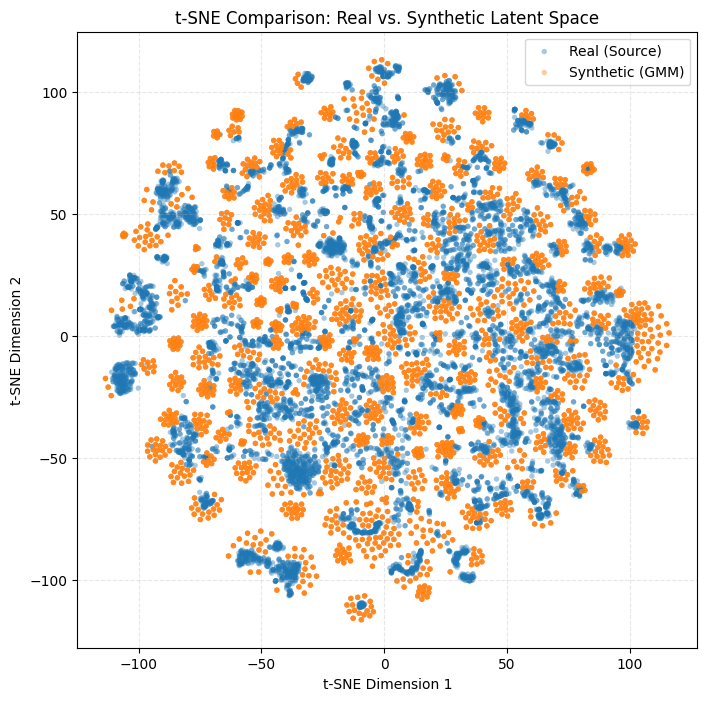

In [ ]:
def plot_tsne(limit=1000):
    real_query = 'content_type:v AND similarity_space:laion_clap'
    synth_query = 'content_type:v AND similarity_space:laion_clap_synthetic'

    real_vecs = fetch_sample(real_query, 'REAL', limit)
    synth_vecs = fetch_sample(synth_query, 'SYNTHETIC', limit)

    if len(real_vecs) == 0 or len(synth_vecs) == 0:
        print("Error: Could not find vectors. Ensure you ran the --generate step!")
        return
    
    print(f"Unique REAL vectors: {len(np.unique(real_vecs, axis=0))}/{len(real_vecs)}")
    print(f"Unique SYNTHETIC vectors: {len(np.unique(synth_vecs, axis=0))}/{len(synth_vecs)}")

    X = np.vstack([real_vecs, synth_vecs])
    labels = np.array(['Real'] * len(real_vecs) + ['Synthetic'] * len(synth_vecs))

    print("Running t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, init='pca', learning_rate='auto')
    X_2d = tsne.fit_transform(X)

    plt.figure(figsize=(8, 8))
    
    plt.scatter(X_2d[labels == 'Real', 0], X_2d[labels == 'Real', 1], 
                c='#1f77b4', label='Real (Source)', alpha=0.4, s=15, edgecolors='none')
    
    plt.scatter(X_2d[labels == 'Synthetic', 0], X_2d[labels == 'Synthetic', 1], 
                c='#ff7f0e', label='Synthetic (GMM)', alpha=0.4, s=15, edgecolors='none')

    plt.title(f't-SNE Comparison: Real vs. Synthetic Latent Space (Subset of {2 * limit} Vectors)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.savefig('tsne_overlap_results.png', bbox_inches='tight')
    plt.show()

plot_tsne(limit=10_000)